## Additional trial: ARCH/GARCH models to predict the volatility of cryptocurrency.

## Introduction & Executive summary

In this section, we implemented further analysis of time-series analysis, ARCH/GARCH to predict the volatility of cryptocurrencies after the milestone 1. 

As we implemented exploratory analysis in milestone 1, we found interesting phenomena in which the volatility of cryptocurrencies may follow some pattern. The pattern is that, periodically we see the spike of the volatility, then the high volatility continues for a while, and finally it can calm down again.

To capture such volatility spike by time-series analysis, ARCH/GARCH model are popularly used. This time, we implemented ARCH(1) and GARCH(1,0,1) as the generally applied starting point. Then, we also applied ARCH(5)/GARCH(5,1,5), and ARCH(10)/GARCH(10,1,10),by obtaining parameters p,o,q from the ARIMA model's evaluation by the graphical method and grid-search method. (Regarding ARCH/GARCH parameters determination from ARIMA model, pls refer below reference (4)).

As results, we could obtain following insights. Generally saying, GARCH can work well with very simple GARCH(1,0,1), while it doesn't show much improvement after we tune our model to GARCH(5,1,5) or GARCH(10,1,10). Therefore, when we have limited information about time series data, we can utilize GARCH(1,0,1) as good starting point to predict the volatility. We understood this is why GARCH(1,0,1) is generally used as the starting point of forecasting volatility in the financial industry custom.

On the other hands, ARCH could not work well with simple ARCH(1). However, when we have information about the parameter from ARIMA modeling, we could improve the model drastically by applying those results i.e. in our case, ARCH(5) and ARCH(10). ARCH tends to improve as we raise the parameter. Therefore, when one already has much information regarding time-series data, he/she can apply ARCH to improve the predicting quality.

The volatility is very important factor to analyze option pricing and to implement risk management in the financial derivative fields and risk management domains. Therefore, our trial can contribute to those area, while the derivative market is not fully developed in the cryptocurrencies field. For details of ARCH/GARCH and those implementation, please refer following reference too.

Reference: 

1. https://readthedocs.org/projects/arch/downloads/pdf/latest/

2. https://arch.readthedocs.io/en/latest/univariate/introduction.html

3. https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html

4. https://medium.com/auquan/time-series-analysis-for-finance-arch-garch-models-822f87f1d755


## Setup for colab and libraries

In [20]:
#It's for google colab usage on google drive.
#Ignore or change folder path that corresponds to your environment.
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

COLAB_PATH = '/content/drive/My Drive/IT5006/FinalPackage'

import sys, os
sys.path.append(COLAB_PATH)
print(sys.path)
## change directory to the path above
os.chdir(COLAB_PATH)

Mounted at /content/drive
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/IT5006/FinalPackage', '/content/drive/My Drive/IT5006/FinalPackage']


In [21]:
!pip install arch

In [22]:
#Install necessary libraries
!pip install pandas

In [23]:
#Import basic libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import time
import pandas_datareader.data as web
import math
import itertools
#handling date
from datetime import datetime

#import libraries for ARCH/GARCH
from arch import arch_model

In [24]:
#For data checking purpuse such as head(), tail(),
#just changed max disaplay row to 100 rows
pd.set_option('display.max_rows', 100)

In [25]:
import warnings
warnings.filterwarnings("ignore")

## Data acquisition & preprocessing

In [26]:
# By following the financial market convention, we take until 4 decimal points.
pd.options.display.float_format = '{:.4f}'.format

In [27]:
main_df = pd.read_csv("./team12_cleandata.csv")
del main_df['Unnamed: 0']
main_df.head()

,day,btc_price,btc_mktcap,btc_volume,eth_price,eth_mktcap,eth_volume,xrp_price,xrp_mktcap,xrp_volume,ltc_price,ltc_mktcap,ltc_volume,btc_price_chg,btc_mktcap_chg,btc_volume_chg,eth_price_chg,eth_mktcap_chg,eth_volume_chg,xrp_price_chg,xrp_mktcap_chg,xrp_volume_chg,ltc_price_chg,ltc_mktcap_chg,ltc_volume_chg,btc_vol20d,eth_vol20d,xrp_vol20d,ltc_vol20d,btc_vol60d,eth_vol60d,xrp_vol60d,ltc_vol60d,btc_SMA10d,eth_SMA10d,xrp_SMA10d,ltc_SMA10d,btc_SMA50d,eth_SMA50d,xrp_SMA50d,...,spx_SMA50d,ndx_SMA50d,gold_SMA50d,us10y_SMA50d,dxy_SMA50d,spx_SMA100d,ndx_SMA100d,gold_SMA100d,us10y_SMA100d,dxy_SMA100d,spx_SMA200d,ndx_SMA200d,gold_SMA200d,us10y_SMA200d,dxy_SMA200d,spx_DiffSMA10d,ndx_DiffSMA10d,gold_DiffSMA10d,us10y_DiffSMA10d,dxy_DiffSMA10d,spx_DiffSMA50d,ndx_DiffSMA50d,gold_DiffSMA50d,us10y_DiffSMA50d,dxy_DiffSMA50d,spx_DiffSMA100d,ndx_DiffSMA100d,gold_DiffSMA100d,us10y_DiffSMA100d,dxy_DiffSMA100d,spx_DiffSMA200d,ndx_DiffSMA200d,gold_DiffSMA200d,us10y_DiffSMA200d,dxy_DiffSMA200d,spx_RSI,ndx_RSI,gold_RSI,us10y_RSI,dxy_RSI
0,2013-04-28,135.3000,1500517590.0000,0.0000,nan,nan,nan,nan,nan,nan,4.2998,73773387.0000,0.0000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1554.4250,2797.0750,1545.0000,1.8590,82.5992,1523.0785,2767.9025,1597.4525,1.9042,81.4073,nan,nan,nan,nan,nan,0.0096,0.0108,0.0325,-0.0139,-0.0026,0.0142,0.0119,-0.0476,-0.0855,-0.0014,0.0351,0.0226,-0.0788,-0.1072,0.0132,nan,nan,nan,nan,nan,56.7657,55.7151,45.5074,35.5147,48.3449
1,2013-04-29,141.9600,1575032004.0000,0.0000,nan,nan,nan,nan,nan,nan,4.3594,74936909.0000,0.0000,0.0492,0.0497,nan,nan,nan,nan,nan,nan,nan,0.0139,0.0158,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1555.8600,2799.2800,1542.7050,1.8558,82.5960,1524.4135,2769.1075,1595.1900,1.9026,81.4303,nan,nan,nan,nan,nan,0.0144,0.0178,0.0243,-0.0122,-0.0060,0.0208,0.0213,-0.0487,-0.0840,-0.0054,0.0419,0.0325,-0.0800,-0.1065,0.0088,nan,nan,nan,nan,nan,60.8551,60.6802,44.5890,35.5147,42.8319
2,2013-04-30,135.3000,1501657493.0000,0.0000,nan,nan,nan,nan,nan,nan,4.1829,72037636.0000,0.0000,-0.0469,-0.0466,nan,nan,nan,nan,nan,nan,nan,-0.0405,-0.0387,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1557.3900,2801.9500,1540.4400,1.8526,82.5844,1525.8060,2770.6700,1593.0850,1.9004,81.4433,nan,nan,nan,nan,nan,0.0138,0.0212,0.0200,-0.0111,-0.0101,0.0229,0.0287,-0.0464,-0.0824,-0.0103,0.0440,0.0403,-0.0779,-0.1055,0.0035,nan,nan,nan,nan,nan,62.4033,64.2059,45.0369,35.5147,37.0423
3,2013-05-01,117.0000,1298951550.0000,0.0000,nan,nan,nan,nan,nan,nan,3.6491,62957992.0000,0.0000,-0.1353,-0.1350,nan,nan,nan,nan,nan,nan,nan,-0.1276,-0.1260,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1558.4500,2804.0800,1538.0500,1.8482,82.5728,1527.0265,2772.2300,1591.1525,1.8977,81.4547,nan,nan,nan,nan,nan,0.0033,0.0129,0.0066,-0.0304,-0.0099,0.0137,0.0232,-0.0542,-0.1018,-0.0113,0.0345,0.0349,-0.0857,-0.1253,0.0023,nan,nan,nan,nan,nan,55.7765,60.8569,41.5966,30.1364,35.9218
4,2013-05-02,103.4300,1148667722.0000,0.0000,nan,nan,nan,nan,nan,nan,3.3888,58565340.0000,0.0000,-0.1160,-0.1157,nan,nan,nan,nan,nan,nan,nan,-0.0713,-0.0698,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1559.5100,2806.1150,1535.8400,1.8434,82.5752,1528.3695,2774.1200,1589.3650,1.8950,81.4718,nan,nan,nan,nan,nan,0.0082,0.0198,0.0122,-0.0264,-0.0024,0.0208,0.0342,-0.0434,-0.0995,-0.0044,0.0416,0.0461,-0.0756,-0.1240,0.0091,nan,nan,nan,nan,nan,60.0052,65.6610,46.1078,30.1364,46.8811


### Data preprocessing

This time, we tried to implement ARCH/GARCH by bitcoin only. So we took the bitcoin price. Then, we convert it into log data and take differencing of log price data, to achieve stationarity and keep consistency with our ARIMA model that we've implemented earlier.

In [28]:
#We take bitcoin price only
btc_df = main_df[['day','btc_price']]
#set day as index
btc_df['day'] = btc_df['day'].astype("datetime64")  
btc_df = btc_df.set_index('day')
#set time frequency as Day = 'D' for executing time series analysis.
btc_df = btc_df.asfreq('D')
#Eliminate nan and fill previous day's price if nan.
btc_df = btc_df.fillna(method='ffill')
#convert into log-price data.
btc_df['btc_price_log'] = np.log(btc_df['btc_price']) 
#take differencing
btc_df['btc_log_diff'] = btc_df['btc_price_log'].diff()
btc_df = btc_df.dropna()
#To ARCH/GARCH model can converge, we need to multiply by 100
#and deal with log_diff data of +4.81% not as 0.0481 but as 4.81
btc_df['btc_log_diff100'] = btc_df['btc_log_diff'] * 100
#Calculate 20 and 60 days annualized volatility, annualized by sqrt(365).
#In equity market, market opening days is around 250 days, so sqrt(250) is 
#often used. But bitcoin market opens everyday, so we applied sqrt(365).
btc_df['btc_vol20d_annualized'] = btc_df['btc_log_diff100'].rolling(20).std() * np.sqrt(365)
btc_df['btc_vol60d_annualized'] = btc_df['btc_log_diff100'].rolling(60).std() * np.sqrt(365)
btc_df = btc_df.dropna()

In [29]:
btc_df.head()

,btc_price,btc_price_log,btc_log_diff,btc_log_diff100,btc_vol20d_annualized,btc_vol60d_annualized
day,,,,,,
2013-06-27,103.3900,4.6385,-0.0029,-0.2907,75.7482,106.6057
2013-06-28,99.6600,4.6018,-0.0367,-3.6744,76.7133,106.0708
2013-06-29,99.6600,4.6018,0.0000,0.0000,66.6890,105.5502
2013-06-30,95.3886,4.5580,-0.0438,-4.3805,59.4626,100.0324
2013-07-01,97.5040,4.5799,0.0219,2.1934,53.6020,95.5796


###Train / test split and check the day of split

In [30]:
#Train / test split of time series data, 90/10. 
split = 0.9
split_day = btc_df.iloc[int(len(btc_df) * split),:].name

In [31]:
#check train/test split day
split_day

Timestamp('2020-04-01 00:00:00', freq='D')

## Function for modeling

In [32]:
def archModel(vol,p,o,q):
  #ARCH model
  am = arch_model(btc_df['btc_log_diff100'], vol=vol,p=p,o=o,q=q,dist='Normal')
  res = am.fit(last_obs=split_day)

  #summary
  print(res.summary())

  #Data visualization of ARCH estimated volatility data from train data
  fig = res.plot(annualize="D")
  fig.set_size_inches(10,5)

  #to annualize, sqrt(365) is multiplied.
  historical_estimate = pd.DataFrame(res.conditional_volatility * np.sqrt(365)).dropna()
  #Data visualization for trained data.
  hist_vol_btc = btc_df[['btc_vol20d_annualized','btc_vol60d_annualized']].merge(historical_estimate, how='inner', on='day')
  fig, axs = plt.subplots(1,1, figsize=(10,5))
  fig.suptitle(str(vol) + ' modeling volatility vs train data volatilities', y=1.05, fontsize=15)
  sns.lineplot(data= hist_vol_btc)
  plt.ylabel('Annualized volatility')
  fig.tight_layout()

  #Volatility prediction. To annualize, prediction volatility is multiplied by np.sqrt(365).
  vol_btc_forecasts = res.forecast(horizon=1, start=split_day)
  test_vol_btc = btc_df[['btc_vol20d_annualized','btc_vol60d_annualized']]\
                  .merge(np.sqrt(vol_btc_forecasts.variance[split_day:])*np.sqrt(365), 
                        how='inner', on='day')
  #Data visualization for prediction vs test data.
  fig, axs = plt.subplots(1,1, figsize=(10,5))
  fig.suptitle(str(vol) + ',Prediction volatility vs test data volatilities', y=1.05, fontsize=15)
  sns.lineplot(data= test_vol_btc)
  plt.ylabel('Annualized volatility')
  fig.tight_layout()

## ARCH

Below is the implementation of ARCH(1) as general starting point, ARCH(5) obtained by grid-search of ARIMA model, and ARCH(10) obtained by graphical method of ARIMA. As results, below implication is obtained.

*  ARCH(1) doesn't show great results. p-values for mu was not good, p>0.05, while omega, alpha showed p<0.05. Also, AIC/BIC was not low with AIC=13888.7, BIC=13906.2, which was much worse (i.e. higher) than AIC/BIC of GARCH(1,0,1) implemented later. Also, graphically, it could not smoothly adjust the conversion level of volatility and just tended to stay at historical average level.

*  On the other hands, regarding ARCH(5) and ARCH(10), it showed improvement as we raise parameter from 1 to 5 then 10. In ARCH(5), coefficients such as mu, omega, alpha 1,2,4,5 (i.e. all coefficients other than alpha 3) showed p<0.05. Also, AIC/BIC improved (i.e. lowerer) drastically to AIC=13575.7, BIC=13616.4. In ARCH(10), while some of coefficients turned to p>0.05, still about half of them are p<0.10. Also, AIC/BIC improved to AIC=13514.4, BIC=13584.1. Graphically, we can obviously see the improvement of the model as we tune our ARCH from ARCH(1) to ARCH(5) and ARCH(10). As we tune our model, the model could smoothly adjust the conversion level of volatility.

As bottom line, regarding ARCH model, we can conclude as followings:

*  ARCH cannot work well by simple form with ARCH(1).
*  On the other hands, as we adjust the model reflecting our ARIMA model's results and increase parameter, the model performance can improve.

Iteration:      1,   Func. Count:      5,   Neg. LLF: 6941.60867588218
Iteration:      2,   Func. Count:     12,   Neg. LLF: 6941.496845736606
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6941.403271856949
Iteration:      4,   Func. Count:     25,   Neg. LLF: 6941.370921694297
Iteration:      5,   Func. Count:     31,   Neg. LLF: 6941.369636059942
Iteration:      6,   Func. Count:     36,   Neg. LLF: 6941.369626008862
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6941.369626009009
            Iterations: 6
            Function evaluations: 36
            Gradient evaluations: 6
                      Constant Mean - ARCH Model Results                      
Dep. Variable:        btc_log_diff100   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -6941.37
Distribution:                  Normal   AIC: 

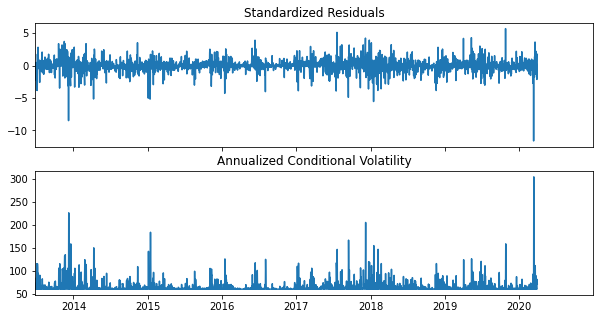

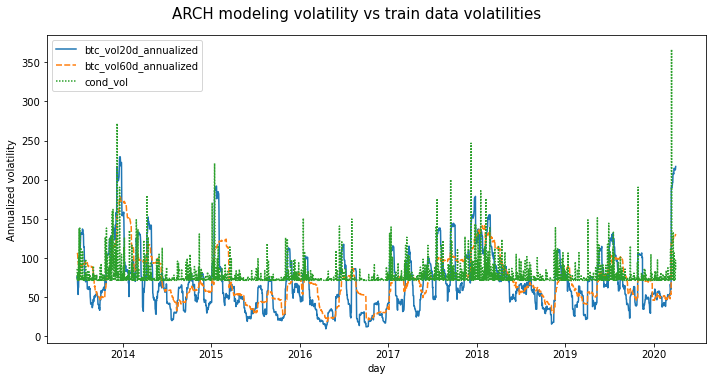

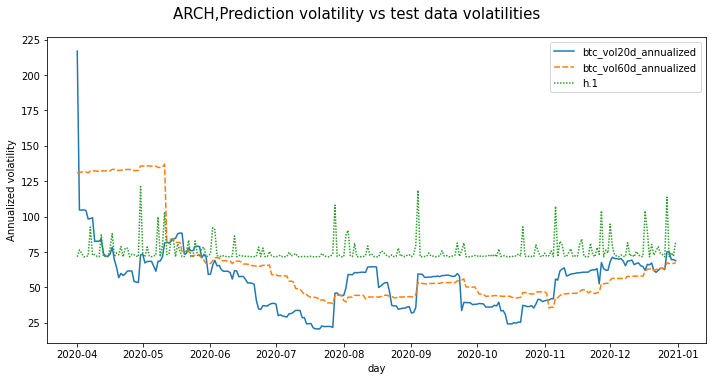

In [33]:
archModel('ARCH',1,0,0)

Iteration:      1,   Func. Count:      9,   Neg. LLF: 6795.260808128423
Iteration:      2,   Func. Count:     20,   Neg. LLF: 6792.494045623103
Iteration:      3,   Func. Count:     31,   Neg. LLF: 6788.3934409355425
Iteration:      4,   Func. Count:     42,   Neg. LLF: 6786.41358997456
Iteration:      5,   Func. Count:     52,   Neg. LLF: 6783.087182174999
Iteration:      6,   Func. Count:     63,   Neg. LLF: 6782.701124424895
Iteration:      7,   Func. Count:     73,   Neg. LLF: 6781.744952786417
Iteration:      8,   Func. Count:     83,   Neg. LLF: 6781.374671800146
Iteration:      9,   Func. Count:     93,   Neg. LLF: 6781.056546534158
Iteration:     10,   Func. Count:    104,   Neg. LLF: 6780.963799651859
Iteration:     11,   Func. Count:    114,   Neg. LLF: 6780.881613759508
Iteration:     12,   Func. Count:    123,   Neg. LLF: 6780.862625919648
Iteration:     13,   Func. Count:    132,   Neg. LLF: 6780.8616183460845
Iteration:     14,   Func. Count:    141,   Neg. LLF: 6780.8615

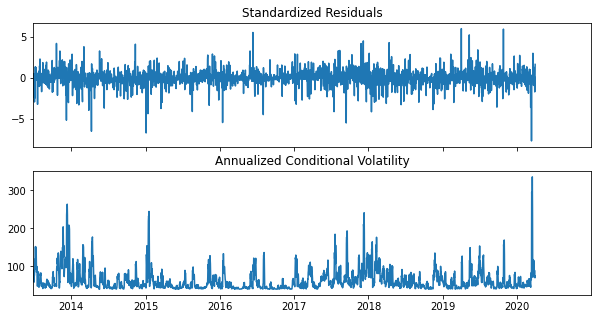

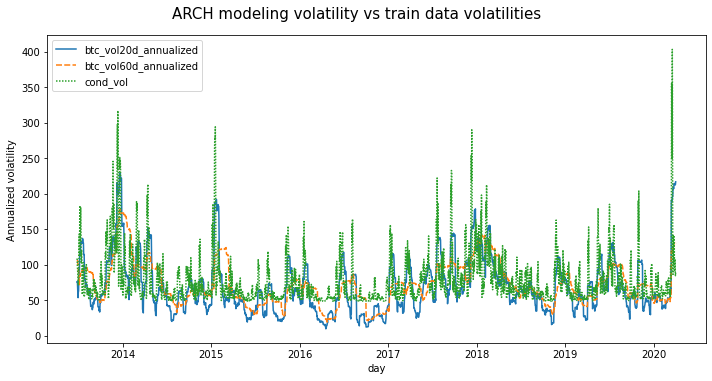

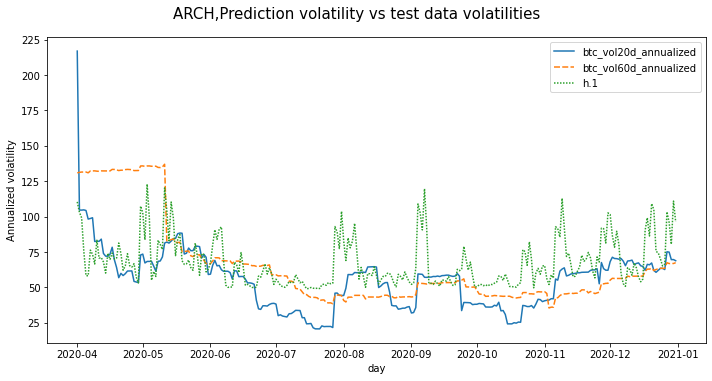

In [34]:
archModel('ARCH',5,0,0)

Iteration:      1,   Func. Count:     14,   Neg. LLF: 6779.75700730506
Iteration:      2,   Func. Count:     30,   Neg. LLF: 6775.809471781495
Iteration:      3,   Func. Count:     46,   Neg. LLF: 6764.589656874068
Iteration:      4,   Func. Count:     62,   Neg. LLF: 6761.357815644675
Iteration:      5,   Func. Count:     77,   Neg. LLF: 6754.864567882921
Iteration:      6,   Func. Count:     92,   Neg. LLF: 6753.764440064854
Iteration:      7,   Func. Count:    108,   Neg. LLF: 6752.409801334335
Iteration:      8,   Func. Count:    123,   Neg. LLF: 6751.887652044085
Iteration:      9,   Func. Count:    138,   Neg. LLF: 6749.476663371809
Iteration:     10,   Func. Count:    153,   Neg. LLF: 6749.062673659512
Iteration:     11,   Func. Count:    168,   Neg. LLF: 6747.972442057022
Iteration:     12,   Func. Count:    183,   Neg. LLF: 6747.12152299082
Iteration:     13,   Func. Count:    199,   Neg. LLF: 6746.617890837257
Iteration:     14,   Func. Count:    215,   Neg. LLF: 6746.4147987

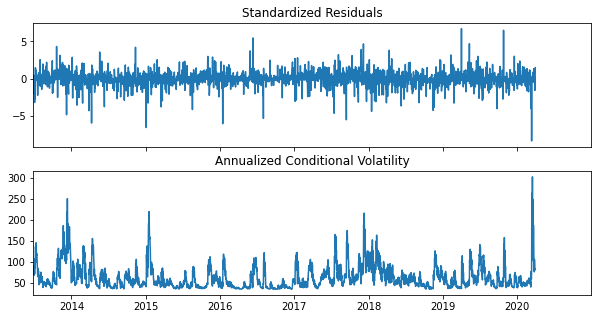

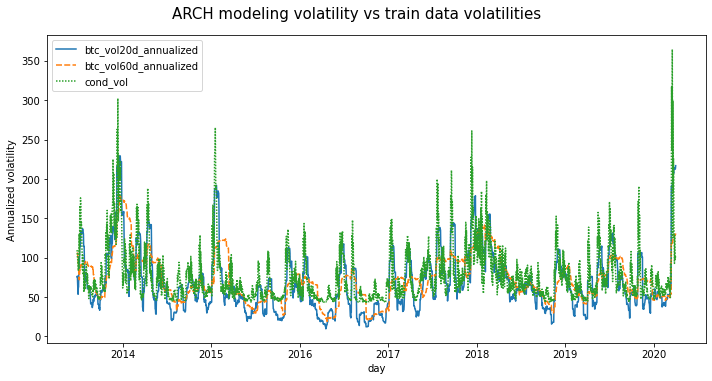

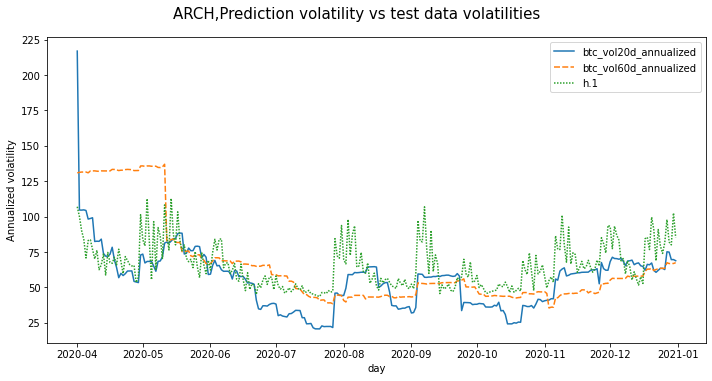

In [35]:
archModel('ARCH',10,0,0)

## GARCH

Below is the implementation of GARCH(1,0,1) as general starting point, GARCH(5,1,5) obtained by grid-search of ARIMA model, and GARCH(10,1,10) obtained by graphical method of ARIMA. As results, below implication is obtained.

*  It showed nice results from the very simple GARCH(1,0,1). p-values for each of mu, omega, alpha, beta were all p<0.05. Also, AIC/BIC is enough low with AIC=13528.0, BIC=13551.2. Graphically, it captures both train data and test data of volatility nicely, in terms of volatility spike, its memory for a while, and smooth adjustment of the conversion level of volatility. 

*  On the other hands, regarding GARCH(5,1,5) and GARCH(10,1,10), those didn't show much improvement. p-values for coefficients became p>0.05 i.e. cannot reject null hypothesis of zero. Also, the improvement of AIC/BIC (note: the lower, the better for AIC/BIC) is limited. Graphically, it doesn't show much improvement from GARCH(1,0,1).

As bottom line, regarding GARCH model, we can conclude as followings:

*  GARCH can work well with low cost, i.e. simple form with less variables of GARCH(1,0,1).
*  However, even though we increase the parameters, it cannot show much improvement.


Iteration:      1,   Func. Count:      6,   Neg. LLF: 6779.9933824248255
Iteration:      2,   Func. Count:     18,   Neg. LLF: 6769.802051307115
Iteration:      3,   Func. Count:     25,   Neg. LLF: 6764.022024409974
Iteration:      4,   Func. Count:     33,   Neg. LLF: 6763.226335382475
Iteration:      5,   Func. Count:     41,   Neg. LLF: 6763.11198815404
Iteration:      6,   Func. Count:     48,   Neg. LLF: 6760.53974821605
Iteration:      7,   Func. Count:     55,   Neg. LLF: 6760.157256254879
Iteration:      8,   Func. Count:     62,   Neg. LLF: 6759.987624868065
Iteration:      9,   Func. Count:     68,   Neg. LLF: 6759.987130536547
Iteration:     10,   Func. Count:     74,   Neg. LLF: 6759.987082305016
Iteration:     11,   Func. Count:     80,   Neg. LLF: 6759.9870769135005
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6759.98707691325
            Iterations: 11
            Function evaluations: 80
            Gradient evaluations: 11

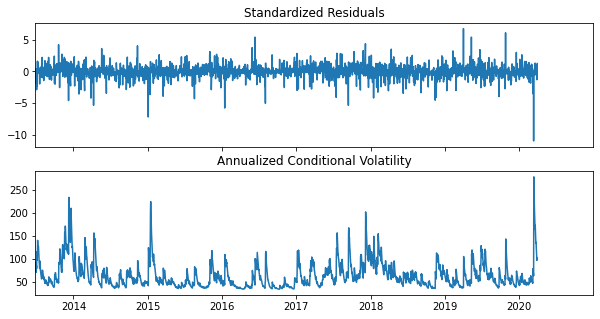

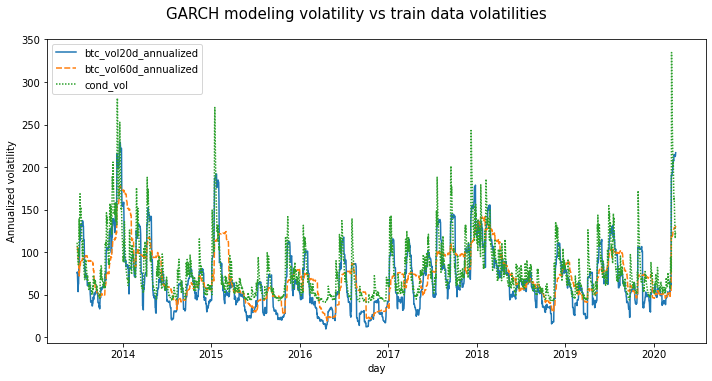

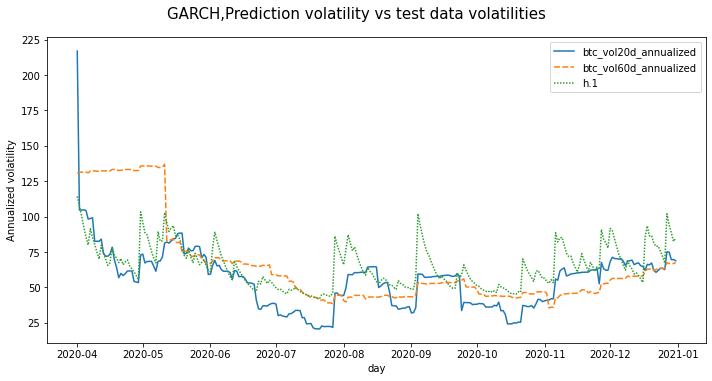

In [36]:
archModel('GARCH',1,0,1)

Iteration:      1,   Func. Count:     15,   Neg. LLF: 6765.7485356376865
Iteration:      2,   Func. Count:     32,   Neg. LLF: 6762.549809596445
Iteration:      3,   Func. Count:     48,   Neg. LLF: 6758.063754903547
Iteration:      4,   Func. Count:     66,   Neg. LLF: 6753.785019013401
Iteration:      5,   Func. Count:     82,   Neg. LLF: 6749.4185154305105
Iteration:      6,   Func. Count:     99,   Neg. LLF: 6746.975642927614
Iteration:      7,   Func. Count:    116,   Neg. LLF: 6746.050873801648
Iteration:      8,   Func. Count:    133,   Neg. LLF: 6745.326525676528
Iteration:      9,   Func. Count:    149,   Neg. LLF: 6743.860613847131
Iteration:     10,   Func. Count:    165,   Neg. LLF: 6742.474572256331
Iteration:     11,   Func. Count:    182,   Neg. LLF: 6742.218946182357
Iteration:     12,   Func. Count:    198,   Neg. LLF: 6741.943118756655
Iteration:     13,   Func. Count:    214,   Neg. LLF: 6740.8201915572145
Iteration:     14,   Func. Count:    230,   Neg. LLF: 6740.44

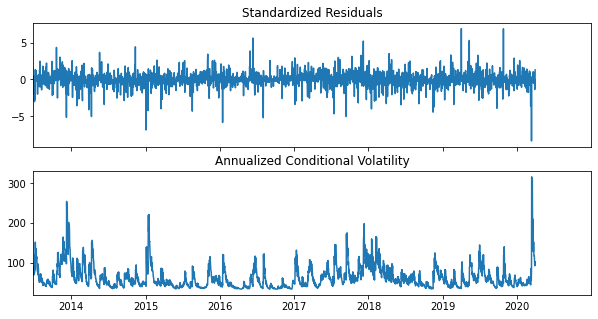

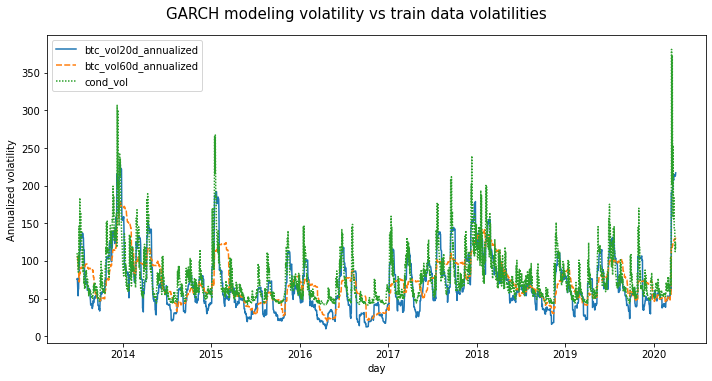

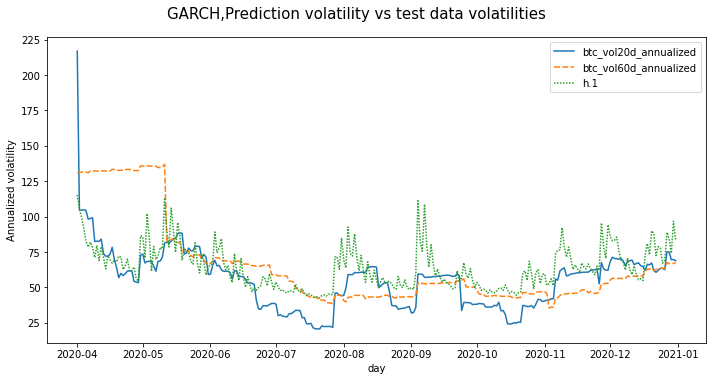

In [37]:
archModel('GARCH',5,1,5)

Iteration:      1,   Func. Count:     25,   Neg. LLF: 6807.9897713907985
Iteration:      2,   Func. Count:     52,   Neg. LLF: 6798.722147262677
Iteration:      3,   Func. Count:     79,   Neg. LLF: 6785.082076740169
Iteration:      4,   Func. Count:    105,   Neg. LLF: 6760.222481759243
Iteration:      5,   Func. Count:    131,   Neg. LLF: 6758.033447709294
Iteration:      6,   Func. Count:    157,   Neg. LLF: 6753.927839532944
Iteration:      7,   Func. Count:    184,   Neg. LLF: 6750.162881471593
Iteration:      8,   Func. Count:    210,   Neg. LLF: 6748.786687951882
Iteration:      9,   Func. Count:    236,   Neg. LLF: 6739.954628738645
Iteration:     10,   Func. Count:    262,   Neg. LLF: 6738.972704253973
Iteration:     11,   Func. Count:    288,   Neg. LLF: 6736.067067296361
Iteration:     12,   Func. Count:    315,   Neg. LLF: 6735.6378737636005
Iteration:     13,   Func. Count:    341,   Neg. LLF: 6733.9970856819255
Iteration:     14,   Func. Count:    367,   Neg. LLF: 6733.28

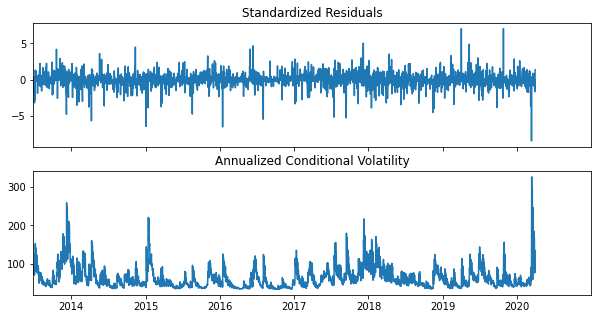

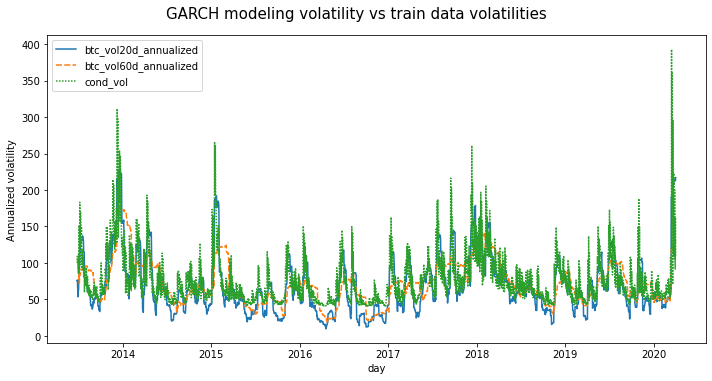

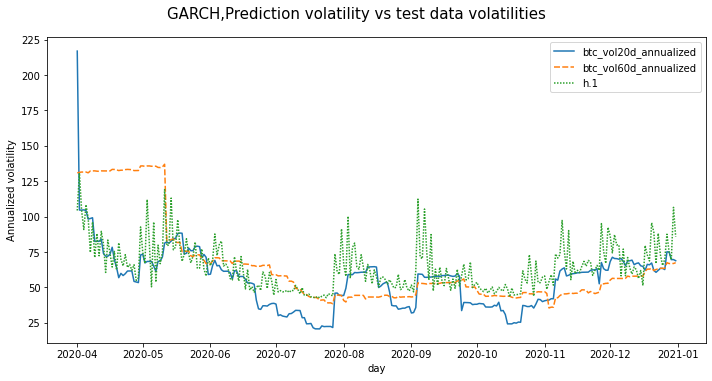

In [38]:
archModel('GARCH',10,1,10)